<a href="https://colab.research.google.com/github/crdsteixeira/OR_project/blob/main/Scheduling_Aircraft_Landings_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download the library

In [1]:
# !pip install docplex
# !pip install cplex

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 640.2/640.2 KB 21.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docplex: filename=docplex-2.24.232-py3-none-any.whl size=682306 sha256=3ee9eebea53ecf32245b652bcdf1ab7642355b881fbb44656c4ddeb5cb07c7be
  Stored in directory: /root/.cache/pip/wheels/cd/84/5d/b9c307d9cf361c49d41ddea36761e226bba3afdfd038673dcd
Successfully built docplex
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 MB 19.8 MB/s eta 0:00:00


In [243]:
from docplex.cp.model import *
import numpy as np

# Info

The format of these data files is:
number of planes (p), freeze time
for each plane i (i=1,...,p):
   - appearance time, 
   - earliest landing time, 
   - target landing time,
   - latest landing time, 
   - penalty cost per unit of time for landing before target, 
   - penalty cost per unit of time for landing after target

for each plane j (j=1,...p): separation time required after 
                                i lands before j can land


### Sigle runway definitions and variables

![image.png](https://github.com/crdsteixeira/OR_project/blob/main/Images/single_run.png?raw=1)


### Multirunway defintions and variables 

![image.png](https://github.com/crdsteixeira/OR_project/blob/main/Images/multi_run.png?raw=1)

## Get data

In [244]:
def read_datafiles(file):
    with open(file, 'r') as data:
        data_lines = data.readlines()
        number_planes = int(data_lines[0].split()[0])
        freeze_time =  int(data_lines[0].split()[1])
        mixed_data = [line.split() for line in data_lines[1:] if not line.isspace()]
        mixed_data = [[(float(j)) for j in i] for i in mixed_data]
        
        flight_details = np.empty([0,6],dtype=float)
        separation_time = np.empty([0,number_planes],dtype=float)
        
        flag = 0
       
        for element in mixed_data:
            if flag == 0: # flight details
                flight_details = np.vstack([flight_details, np.array(element)])
                flag = 1
                element_final = []
            else:  # separation_times
                element_final.extend(element)
                if len(element_final) == number_planes:
                    separation_time = np.vstack([separation_time, np.array(element_final)])
                    flag = 0
                
#         print(f" number planes: {number_planes}")
#         print(f" freeze time: {freeze_time}")
#         print(f" mixed data: {mixed_data}")
#         print(f" flight details: {flight_details}")
#         print(f" separation time: {separation_time}")
    
    return number_planes, freeze_time, flight_details, separation_time


In [7]:
read_datafiles("./Data/airland1.txt")

(10, 10, array([[ 54., 129., 155., 559.,  10.,  10.],
        [120., 195., 258., 744.,  10.,  10.],
        [ 14.,  89.,  98., 510.,  30.,  30.],
        [ 21.,  96., 106., 521.,  30.,  30.],
        [ 35., 110., 123., 555.,  30.,  30.],
        [ 45., 120., 135., 576.,  30.,  30.],
        [ 49., 124., 138., 577.,  30.,  30.],
        [ 51., 126., 140., 573.,  30.,  30.],
        [ 60., 135., 150., 591.,  30.,  30.],
        [ 85., 160., 180., 657.,  30.,  30.]]), array([[9.9999e+04, 3.0000e+00, 1.5000e+01, 1.5000e+01, 1.5000e+01,
         1.5000e+01, 1.5000e+01, 1.5000e+01, 1.5000e+01, 1.5000e+01],
        [3.0000e+00, 9.9999e+04, 1.5000e+01, 1.5000e+01, 1.5000e+01,
         1.5000e+01, 1.5000e+01, 1.5000e+01, 1.5000e+01, 1.5000e+01],
        [1.5000e+01, 1.5000e+01, 9.9999e+04, 8.0000e+00, 8.0000e+00,
         8.0000e+00, 8.0000e+00, 8.0000e+00, 8.0000e+00, 8.0000e+00],
        [1.5000e+01, 1.5000e+01, 8.0000e+00, 9.9999e+04, 8.0000e+00,
         8.0000e+00, 8.0000e+00, 8.0000e+00, 

# The MIP model

In [281]:
from docplex.mp.progress import ProgressListener, ProgressClock
from IPython import display
import matplotlib.pyplot as plt

class MipGapPlotter(ProgressListener):
    
    def __init__(self):
        ProgressListener.__init__(self, ProgressClock.All)
        plt.ion()
        self.fig = plt.figure(figsize=(10,4))
#         self.ax = self.fig.add_subplot(1,1,1)
    
    def notify_start(self):
        super(MipGapPlotter, self).notify_start()
        self.times =[]
        self.gaps = []
#         self.lines, = self.ax.plot([],[], 'o')
        plt.xlabel('time (ms)')
        plt.ylabel('gap (%)')
        
    def notify_progress(self, pdata):
        gap = pdata.mip_gap
        time = pdata.time
        self.times.append(1000* time)
        self.gaps.append(100*gap)
#         display.clear_output(wait=True)
        print(f"gap:. {gap}")
        plt.plot(self.times, self.gaps)
#         display.display(plt.gcf())
        

In [282]:
def MIP_model(file_name,R):
    from docplex.mp.model import Model
    mdl = Model("Scheduling Aircraft Landing - Multi Runway Static Case")
    
    P, freeze_time, flight_details, separation_time = read_datafiles(file_name)
    
    # The first column relates to the actual appearence time of the plane so will not be taken into account for our decision variables

    E = flight_details[:,1]  #earliest landing time,
    T = flight_details[:,2]  #target landing time,
    L = flight_details[:,3]  #latest landing time,
    g = flight_details[:,4]  #penalty cost per unit of time for landing before target,
    h = flight_details[:,5]  #penalty cost per unit of time for landing after target
    range_LT = max(flight_details[:,3]) - min(flight_details[:,1]) #landing range time

    # here we consider separation time between planes that land in different runways, fundamentally their value is the same as the separation time matrix but in constraints it should be multiplied by the binary variable that says if the planes land in the same runway or not
    s = np.zeros([P,P],dtype=float)

    ij = [(i,j) for i in np.arange(P) for j in np.arange(P)] # indexes for plane i and j landing in the same runway
    ir = [(i,r) for i in np.arange(P) for r in np.arange(R)] # indexes for plane i landing in runway r
    
    # Creating the time spaces
    W = []
    V = []
    U = []
    for i in range(P):
        for j in range(P):
            if i != j:
                if (L[i] < E[j]) and ((L[i] + separation_time[i, j]) <= E[j]):
                    W.append((i,j))
                elif (L[j] < E[j]) and ((L[i] + separation_time[i, j]) > E[j]): # windows intersept but we know that i lands before j
                    V.append((i,j))
                elif ((E[j] <= E[i]) and (E[i] <= L[j])) or ((E[j] <= L[i]) and (L[i] <= L[j])) or ((E[i] <= E[j]) and (E[j] <= L[i])) or ((E[i] <= L[j]) and (L[j] <= L[i])):
                    U.append((i,j)) # we don't know the order in which one lands
            else: 
                continue

    # Defining decision variables
    alpha   = mdl.continuous_var_dict(np.arange(P),lb=0,ub=mdl.infinity, name="alpha") # how soon a plane lands before target time
    beta    = mdl.continuous_var_dict(np.arange(P),lb=0,ub=mdl.infinity, name="beta") # how soon a plane lands after target time
    x       = mdl.continuous_var_dict(np.arange(P),lb=0,ub=mdl.infinity, name="x") # landing time for a plane
    sigma   = mdl.binary_var_dict(ij,lb=0,ub=1, name="sigma") # binary variable: 1 if plane i lands before plane j, 0 elsewhere
    y       = mdl.binary_var_dict(ir,lb=0,ub=1, name="y") # 1 if plane i lands on runway  r , 0 otherwise
    z       = mdl.binary_var_dict(ij,lb=0,ub=1, name="z") # 1 if planes i and  j land on the same runway, 0 otherwise

    # Adding constraints    
    mdl.add_constraints(x[i]>=E[i] for i in np.arange(P)) # Const 1 - Landing time of plane i must be later than the earliest landing time
    mdl.add_constraints(x[i]<=L[i] for i in np.arange(P)) # Const 1 - Landing time of plane i must be earlier than the before latest landing time
    mdl.add_constraints((sigma[i,j]+sigma[j,i])==1 for i in np.arange(P) for j in np.arange(P) if j>i)  # Const 2 - Plain i must land before plain j or plain j before plain i
    mdl.add_constraints(alpha[i]>=(T[i]-x[i]) for i in np.arange(P)) # Const 14 - How soon plane i lands before T[i] must be larger than T[i] - x[i]
    mdl.add_constraints(alpha[i]<=(T[i]-E[i]) for i in np.arange(P)) # Const 15 - How soon plane i lands before T[i] must be smaller than T[i] - E[i]
    mdl.add_constraints(alpha[i]>= 0 for i in np.arange(P)) # Const 15 - How soon plane i lands before T[i] must be at least zero
    mdl.add_constraints(beta[i]>=(x[i]-T[i]) for i in np.arange(P))  # Const 16 - How soon plane i lands after T[i] must be larger than x[i] - T[i]
    mdl.add_constraints(beta[i]<=(L[i]-T[i]) for i in np.arange(P))  # Const 17 - How soon plane i lands after T[i] must be smaller than L[i] - T[i]
    mdl.add_constraints(beta[i]>= 0 for i in np.arange(P))  # Const 17 - How soon plane i lands after T[i] must be at least zero
    mdl.add_constraints(x[i]==(T[i]-alpha[i]+beta[i]) for i in np.arange(P))  # Const 18 - Landing time is equal to target time minus arriving early or plus arriving late
   
    mdl.add_constraints(mdl.sum(y[i,r] for r in np.arange(R))==1 for i in np.arange(P))     # Const 28 - Plane i can only land in 1 runaway
    mdl.add_constraints(z[i,j]==z[j,i] for i in np.arange(P) for j in np.arange(P) if j>i)  # Const 29 - Symetry constraint: If plane i lands in the same runaway as plane j, plane j lands in the same runaway as plane i
    mdl.add_constraints(z[i,j]>=(y[i,r]+y[j,r]-1) for r in np.arange(R) for i in np.arange(P) for j in np.arange(P) if j>i) # Const 30 - If there is any runaway r for which y[i,r]=y[j,r]=1 then z[i,j]=1. If z[i,j]=0 then the planes i and j cannot land on the same runaway 
    
    # Const 6 - If plane i lands before j we know that they belong in subspace W or V 
    mdl.add_constraints(sigma[i,j] == 1 for i in np.arange(P) for j in np.arange(P) if ((i,j) in V) or ((i,j) in W))
          
    # Const 12 - Separation time between plane i and plane j must be respected
    #mdl.add_constraints(x[j] >= (x[i] + (separation_time[i,j]*sigma[i,j]) - ((L[i] - E[j])*sigma[j,i])) for i in np.arange(P) 
    #                    for j in np.arange(P) if (i,j) in U and i != j)  

    # Const 31 - Landing times should respect separation times considering if they land in the same runway or not in subspace V
    mdl.add_constraints(x[j] >= (x[i] + separation_time[i,j]*z[i,j] + s[i,j]*(1-z[i,j])) for i in np.arange(P) 
                        for j in np.arange(P) if (i,j) in V)

    # Const 33 - Landing times should respect separation times considering if they land in the same runway or not in subspace U
    mdl.add_constraints(x[j] >= (x[i] + separation_time[i,j]*z[i,j] + 
                                 s[i,j]*(1-z[i,j]) - (L[i] + max(separation_time[i,j], s[i,j]) - E[j])*sigma[j,i]) 
                        for i in np.arange(P) for j in np.arange(P) if (i,j) in U)


    cost_function = mdl.sum(beta[i] * h[i] + alpha[i] * g[i] for i in np.arange(P))

    mdl.minimize(cost_function)
    
    mdl.print_information()
    mdl.add_progress_listener(MipGapPlotter())

    msol = mdl.solve(clean_before_solve = True)
    assert msol is not None, "model can't solve"
    msol.export(f"{file_name}_{R}runway_solution.json")
    plt.savefig(f"{file_name}_{R}runway_gap-runtime.png")
    with open(f"{file_name}_{R}_runway_solution_time.txt", 'w') as f:
        print(mdl.solve_details, file = f)
        

    return mdl

Model: Scheduling Aircraft Landing - Multi Runway Static Case
 - number of variables: 240
   - binary=210, integer=0, continuous=30
 - number of constraints: 325
   - linear=325
 - parameters: defaults
 - objective: minimize
 - problem type is: MILP
gap:. 0.9999999999999934
gap:. 0.9999999999999934
gap:. 0.9999999999999218
gap:. 0.9999999999999218
gap:. 0.7343749999999424
gap:. 0.5853658536584649
gap:. 0.5853658536584649
gap:. 0.5539772727266994
gap:. 0.4285714285713673
gap:. 0.4285714285713673
gap:. 0.4285714285713673
gap:. 0.4285714285713673
gap:. 0.4285714285713673
gap:. 0.4285714285713673
* model Scheduling Aircraft Landing - Multi Runway Static Case solved with objective = 700.000
objective: 700.000
status: OPTIMAL_SOLUTION(2)
  alpha_4=5.000
  alpha_5=9.000
  alpha_6=4.000
  beta_0=10.000
  beta_7=2.000
  x_0=165.000
  x_1=258.000
  x_2=98.000
  x_3=106.000
  x_4=118.000
  x_5=126.000
  x_6=134.000
  x_7=142.000
  x_8=150.000
  x_9=180.000
  sigma_0_1=1
  sigma_0_9=1
  sigma_2_0=

Model: Scheduling Aircraft Landing - Multi Runway Static Case
 - number of variables: 525
   - binary=480, integer=0, continuous=45
 - number of constraints: 780
   - linear=780
 - parameters: defaults
 - objective: minimize
 - problem type is: MILP
gap:. 0.9999999999999971
gap:. 0.9999999999999971
gap:. 0.9999999999999971
gap:. 0.9999999999999971
gap:. 0.9999999999998958
gap:. 0.9999999999998958
gap:. 0.9999999999998958
gap:. 0.9999999999998958
gap:. 0.9999999999998958
gap:. 0.9999999999997917
gap:. 0.9999999999997917
gap:. 0.9999999999997917
gap:. 0.9999999999995238
gap:. 0.9999999999995238
gap:. 0.9999999999995238
gap:. 0.9761904761900114
gap:. 0.9761904761900114
gap:. 0.904761904761474
* model Scheduling Aircraft Landing - Multi Runway Static Case solved with objective = 210.000
objective: 210.000
status: OPTIMAL_SOLUTION(2)
  beta_6=7.000
  x_0=155.000
  x_1=250.000
  x_2=93.000
  x_3=98.000
  x_4=111.000
  x_5=120.000
  x_6=128.000
  x_7=120.000
  x_8=128.000
  x_9=151.000
  x_10

Model: Scheduling Aircraft Landing - Multi Runway Static Case
 - number of variables: 900
   - binary=840, integer=0, continuous=60
 - number of constraints: 1340
   - linear=1340
 - parameters: defaults
 - objective: minimize
 - problem type is: MILP
gap:. 0.9999999999999973
gap:. 0.9999999999999973
gap:. 0.9999999999998
gap:. 0.9999999999998
gap:. 0.9999999999998
gap:. 0.9999999999998
gap:. 0.9999999999997436
gap:. 0.9999999999997436
gap:. 0.9999999999997436
gap:. 0.9999999999997436
gap:. 0.9658119658117182
gap:. 0.9658119658117182
gap:. 0.9487179487177047
gap:. 0.8888888888883932
gap:. 0.8888888888883932
gap:. 0.8888888888883907
gap:. 0.6666666666655375
* model Scheduling Aircraft Landing - Multi Runway Static Case solved with objective = 60.000
objective: 60.000
status: OPTIMAL_SOLUTION(2)
  beta_8=2.000
  x_0=82.000
  x_1=197.000
  x_2=160.000
  x_3=117.000
  x_4=261.000
  x_5=106.000
  x_6=229.000
  x_7=108.000
  x_8=134.000
  x_9=130.000
  x_10=149.000
  x_11=126.000
  x_12=336.

Model: Scheduling Aircraft Landing - Multi Runway Static Case
 - number of variables: 880
   - binary=820, integer=0, continuous=60
 - number of constraints: 1150
   - linear=1150
 - parameters: defaults
 - objective: minimize
 - problem type is: MILP
gap:. 0.9999999999999981
gap:. 0.9999999999999981
gap:. 0.9999999999999981
gap:. 0.977314286943612
gap:. 0.5247431043807265
gap:. 0.5247431043807265
gap:. 0.4784888825628467
gap:. 0.4784888825628467
gap:. 0.4784888825628467
gap:. 0.4784888825628467
gap:. 0.47848888256284655
gap:. 0.46607195119529615
gap:. 0.46607195119529604
gap:. 0.46607195119529604
gap:. 0.46607195119529604
gap:. 0.46607195119529604
gap:. 0.46607195119529604
gap:. 0.46607195119529604
gap:. 0.46607195119529604
gap:. 0.46607195119529604
gap:. 0.46607195119529604
gap:. 0.46607195119529604
gap:. 0.46607195119529604
gap:. 0.46607195119529604
gap:. 0.46160090754627087
gap:. 0.46160090754627087
gap:. 0.46160090754627087
gap:. 0.4546687712071199
gap:. 0.4546687712071199
gap:. 0

Model: Scheduling Aircraft Landing - Multi Runway Static Case
 - number of variables: 900
   - binary=840, integer=0, continuous=60
 - number of constraints: 1340
   - linear=1340
 - parameters: defaults
 - objective: minimize
 - problem type is: MILP
gap:. 0.9999999999999981
gap:. 0.9999999999999981
gap:. 0.9999999999999981
gap:. 0.9999999999999981
gap:. 0.9999999999999507
gap:. 0.9999999999999507
gap:. 0.9999999999999507
gap:. 0.9999999999999507
gap:. 0.9985925404644124
gap:. 0.9985925404644124
gap:. 0.9934553131596976
gap:. 0.9934553131596976
gap:. 0.9776130195021338
gap:. 0.9776130195021338
gap:. 0.9711357290412904
gap:. 0.9711357290412904
gap:. 0.9589149359420548
gap:. 0.9589149359420548
gap:. 0.9530312077333548
gap:. 0.9530312077333548
gap:. 0.9472906403940415
gap:. 0.9472906403940415
gap:. 0.946821487215529
gap:. 0.9149981252342733
gap:. 0.9149981252342733
gap:. 0.9135559125444987
gap:. 0.8644642085574301
gap:. 0.8644642085574301
gap:. 0.8631033532871096
gap:. 0.8631033532871096

Model: Scheduling Aircraft Landing - Multi Runway Static Case
 - number of variables: 880
   - binary=820, integer=0, continuous=60
 - number of constraints: 1150
   - linear=1150
 - parameters: defaults
 - objective: minimize
 - problem type is: MILP
gap:. 0.9999999999999983
gap:. 0.9999999999999983
gap:. 0.9999999999999983
gap:. 0.9850513175363467
gap:. 0.9850513175363467
gap:. 0.9819926298284293
gap:. 0.6842985333504467
gap:. 0.6842985333504467
gap:. 0.6824517833361381
gap:. 0.6824517833361381
gap:. 0.6594576926791568
gap:. 0.6594576926791568
gap:. 0.6594576926791568
gap:. 0.6513404883815307
gap:. 0.6513404883815307
gap:. 0.6488150448301693
gap:. 0.6080322758427062
gap:. 0.6080322758427062
gap:. 0.6011919370977415
gap:. 0.6011919370977415
gap:. 0.5946337515521418
gap:. 0.5946337515521418
gap:. 0.5894676137446183
gap:. 0.5894676137446183
gap:. 0.5859261642971929
gap:. 0.5859261642971929
gap:. 0.5851233784452753
gap:. 0.5851233784452753
gap:. 0.5849720959904747
gap:. 0.584972095990474

Model: Scheduling Aircraft Landing - Multi Runway Static Case
 - number of variables: 900
   - binary=840, integer=0, continuous=60
 - number of constraints: 1340
   - linear=1340
 - parameters: defaults
 - objective: minimize
 - problem type is: MILP
gap:. 0.9999999999999982
gap:. 0.9999999999999982
gap:. 0.9999999999999982
gap:. 0.9999999999999982
gap:. 0.9999999999999561
gap:. 0.9999999999999561
gap:. 0.9999999999999561
gap:. 0.9999999999999561
gap:. 0.9999999999999561
gap:. 0.9999999999999561
gap:. 0.9950213371265567
gap:. 0.9950213371265567
gap:. 0.9946996466430659
gap:. 0.9946996466430659
gap:. 0.9840948525158618
gap:. 0.9840948525158618
gap:. 0.9826647037172921
gap:. 0.9826647037172921
gap:. 0.9768851214574469
gap:. 0.9768851214574469
gap:. 0.97222744360898
gap:. 0.97222744360898
gap:. 0.9675280931085459
gap:. 0.9675280931085459
gap:. 0.9667945906432326
gap:. 0.9667945906432326
gap:. 0.9650584795321213
gap:. 0.9650584795321213
gap:. 0.9633223684210102
gap:. 0.9633223684210102
ga

Model: Scheduling Aircraft Landing - Multi Runway Static Case
 - number of variables: 1920
   - binary=1830, integer=0, continuous=90
 - number of constraints: 2070
   - linear=2070
 - parameters: defaults
 - objective: minimize
 - problem type is: MILP
gap:. 0.9263629411121933
gap:. 0.9263629411121933
gap:. 0.9263629411121933
gap:. 0.7050022784070876
gap:. 0.6996870041441513
gap:. 0.6996870041441513
gap:. 0.6088956377724005
gap:. 0.6088956377724005
gap:. 0.5971427966452344
gap:. 0.5971427966452344
gap:. 0.5815712163214554
gap:. 0.5815712163214554
gap:. 0.5797250898590054
gap:. 0.5753324660510613
gap:. 0.5753324660510613
gap:. 0.5716933892839237
gap:. 0.5716933892839237
gap:. 0.5640671586392411
gap:. 0.5640671586392411
gap:. 0.5614901923495035
gap:. 0.5614901923495035
gap:. 0.5612465256157575
gap:. 0.5612465256157575
gap:. 0.5611810519737795
gap:. 0.5611810519737795
gap:. 0.5611810519737795
gap:. 0.5611810519737795
gap:. 0.5611810519737795
* model Scheduling Aircraft Landing - Multi Ru

Model: Scheduling Aircraft Landing - Multi Runway Static Case
 - number of variables: 1950
   - binary=1860, integer=0, continuous=90
 - number of constraints: 2505
   - linear=2505
 - parameters: defaults
 - objective: minimize
 - problem type is: MILP
gap:. 0.9999999999999806
gap:. 0.9999999999999806
gap:. 0.9999999999999806
gap:. 0.9999999999999806
gap:. 0.9999999999999806
gap:. 0.9999999999999806
gap:. 0.9999999999999186
gap:. 0.9999999999999186
gap:. 0.9999999999999186
gap:. 0.9999999999999186
gap:. 0.9999999999999186
gap:. 0.9999999999999186
gap:. 0.9999999999999186
gap:. 0.9999999999999186
gap:. 0.9999999999999186
gap:. 0.9999999999999186
gap:. 0.9999999999999186
gap:. 0.8908786938565904
gap:. 0.8877179387826747
gap:. 0.8762849629451235
gap:. 0.8665500092096594
gap:. 0.7980037360245635
gap:. 0.7933896081672578
gap:. 0.7933896081672578
gap:. 0.7933896081672578
gap:. 0.7933896081672578
gap:. 0.7933896081672578
gap:. 0.7933896081672578
gap:. 0.7933896081672578
gap:. 0.7933896081672

Model: Scheduling Aircraft Landing - Multi Runway Static Case
 - number of variables: 4048
   - binary=3916, integer=0, continuous=132
 - number of constraints: 4254
   - linear=4254
 - parameters: defaults
 - objective: minimize
 - problem type is: MILP
gap:. 0.951895424836574
gap:. 0.951895424836574
gap:. 0.7237237237236148
gap:. 0.7237237237236148
gap:. 0.6246246246245306
gap:. 0.6246246246245306
gap:. 0.6114952161462868
gap:. 0.6114952161462868
gap:. 0.6016023353508922
* model Scheduling Aircraft Landing - Multi Runway Static Case solved with objective = 278.000
objective: 278.000
status: OPTIMAL_SOLUTION(2)
  alpha_3=80.000
  alpha_6=27.000
  alpha_7=32.000
  beta_2=80.000
  x_1=137.000
  x_2=351.000
  x_3=271.000
  x_4=431.000
  x_5=503.000
  x_6=599.000
  x_7=695.000
  x_8=895.000
  x_9=967.000
  x_10=1167.000
  x_11=1239.000
  x_12=1439.000
  x_13=1519.000
  x_14=1591.000
  x_15=1791.000
  x_16=1871.000
  x_17=1943.000
  x_18=2143.000
  x_19=2223.000
  x_20=2295.000
  x_21=2391

Model: Scheduling Aircraft Landing - Multi Runway Static Case
 - number of variables: 4092
   - binary=3960, integer=0, continuous=132
 - number of constraints: 5200
   - linear=5200
 - parameters: defaults
 - objective: minimize
 - problem type is: MILP
* model Scheduling Aircraft Landing - Multi Runway Static Case solved with objective = 0.000
objective: 0.000
status: OPTIMAL_SOLUTION(2)
  x_1=137.000
  x_2=271.000
  x_3=351.000
  x_4=431.000
  x_5=503.000
  x_6=626.000
  x_7=727.000
  x_8=895.000
  x_9=967.000
  x_10=1167.000
  x_11=1239.000
  x_12=1439.000
  x_13=1519.000
  x_14=1591.000
  x_15=1791.000
  x_16=1871.000
  x_17=1943.000
  x_18=2143.000
  x_19=2223.000
  x_20=2295.000
  x_21=2391.000
  x_22=2591.000
  x_23=2663.000
  x_24=2863.000
  x_25=2943.000
  x_26=3023.000
  x_27=3103.000
  x_28=3175.000
  x_29=3271.000
  x_30=3471.000
  x_31=3543.000
  x_32=3743.000
  x_33=3815.000
  x_34=3911.000
  x_35=4111.000
  x_36=4191.000
  x_37=4271.000
  x_38=4343.000
  x_39=4439.000
 

Model: Scheduling Aircraft Landing - Multi Runway Static Case
 - number of variables: 5200
   - binary=5050, integer=0, continuous=150
 - number of constraints: 6607
   - linear=6607
 - parameters: defaults
 - objective: minimize
 - problem type is: MILP
gap:. 0.9999999999999993
gap:. 0.9999999999999993
gap:. 0.9999999999999993
gap:. 0.9896719769004072
gap:. 0.9896719769004072
gap:. 0.9880537838493406
gap:. 0.9880537838493406
gap:. 0.9876044779536256
gap:. 0.2943092146041344
gap:. 0.2943092146041344
gap:. 0.2921632781659154
gap:. 0.1302590283924344
gap:. 0.1302590283924344
gap:. 0.1302590283924344
gap:. 0.12321946264119966
gap:. 0.12321946264119966
gap:. 0.12321946264119966
gap:. 0.10025205032177509
gap:. 0.10025205032177509
gap:. 0.09184166154709969
gap:. 0.09184166154709969
gap:. 0.09184166154709969
* model Scheduling Aircraft Landing - Multi Runway Static Case solved with objective = 1950.000
objective: 1950.000
status: OPTIMAL_SOLUTION(2)
  alpha_2=8.000
  alpha_3=1.000
  alpha_5=6

Model: Scheduling Aircraft Landing - Multi Runway Static Case
 - number of variables: 5250
   - binary=5100, integer=0, continuous=150
 - number of constraints: 7832
   - linear=7832
 - parameters: defaults
 - objective: minimize
 - problem type is: MILP
gap:. 0.9999999999999993
gap:. 0.9999999999999993
gap:. 0.9454545454542017
gap:. 0.9454545454542017
gap:. 0.9454545454542017
gap:. 0.9454545454542017
gap:. 0.9454545454542017
gap:. 0.9454545454542017
gap:. 0.9454545454542017
gap:. 0.9454545454542017
gap:. 0.9454545454542017
gap:. 0.9454545454542017
gap:. 0.9454545454542017
gap:. 0.9281385281381906
gap:. 0.9281385281381906
gap:. 0.8915584415581175
gap:. 0.8915584415581175
gap:. 0.8207792207789225
gap:. 0.8207792207789225
gap:. 0.7838674514930668
gap:. 0.7838674514930668
gap:. 0.7838674514930635
gap:. 0.5597299936844956
gap:. 0.4444444443206628
gap:. 0.4444444443206628
gap:. 0.4444444443206628
gap:. 0.22222222204921516
gap:. 0.0
gap:. 0.0
* model Scheduling Aircraft Landing - Multi Runwa

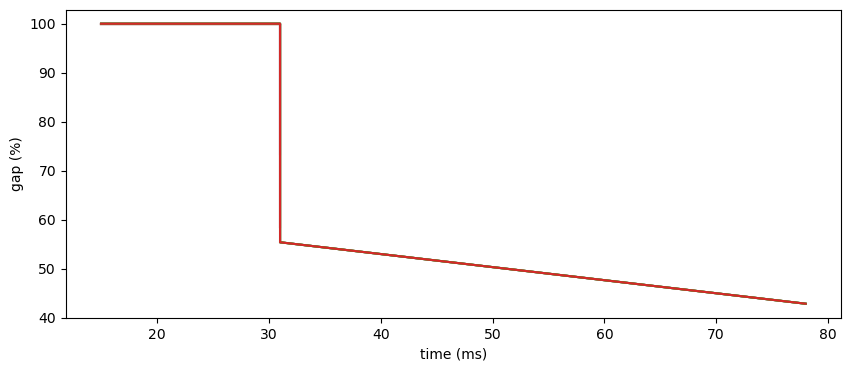

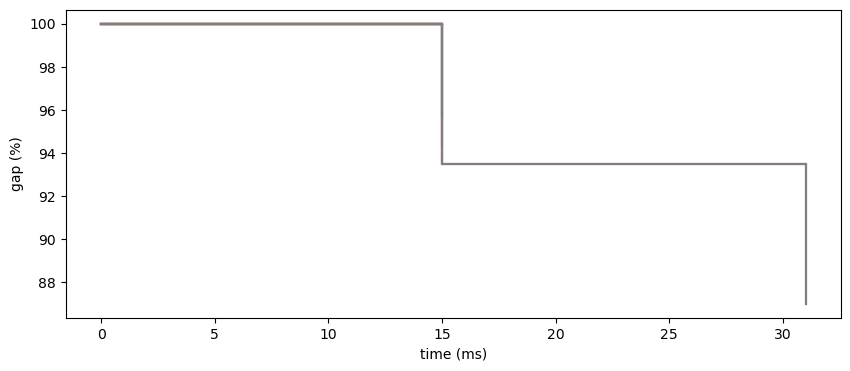

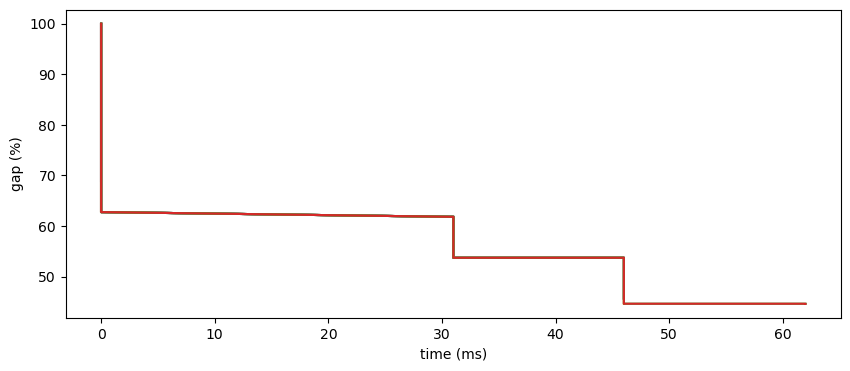

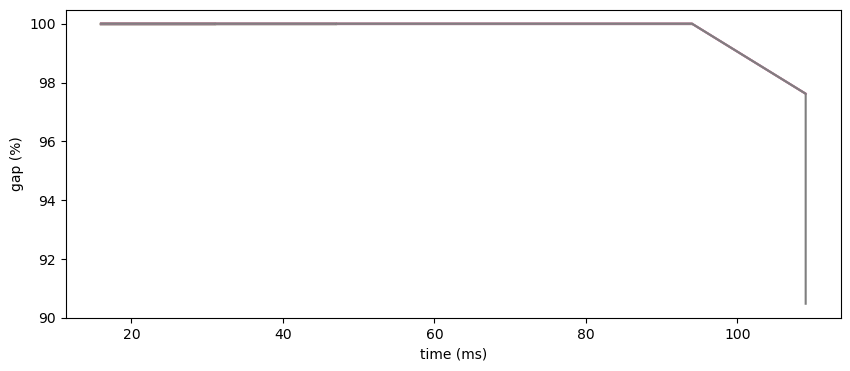

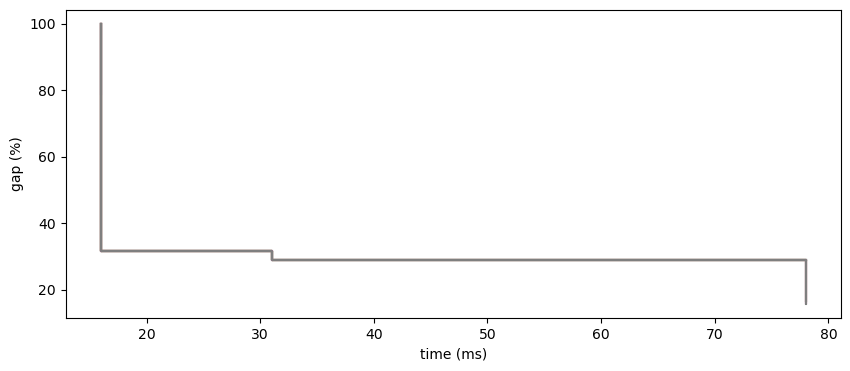

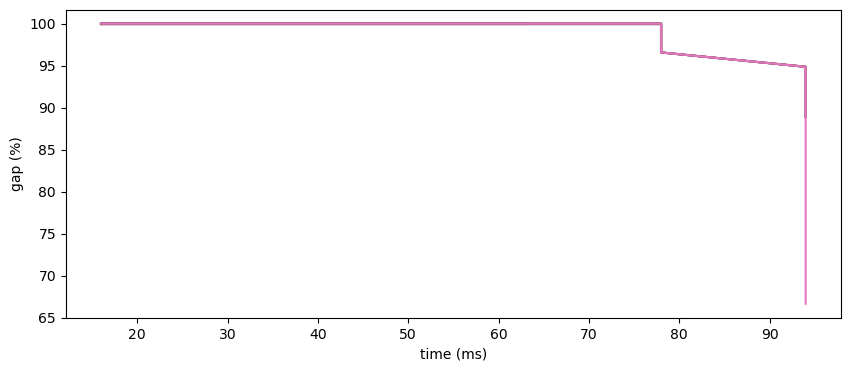

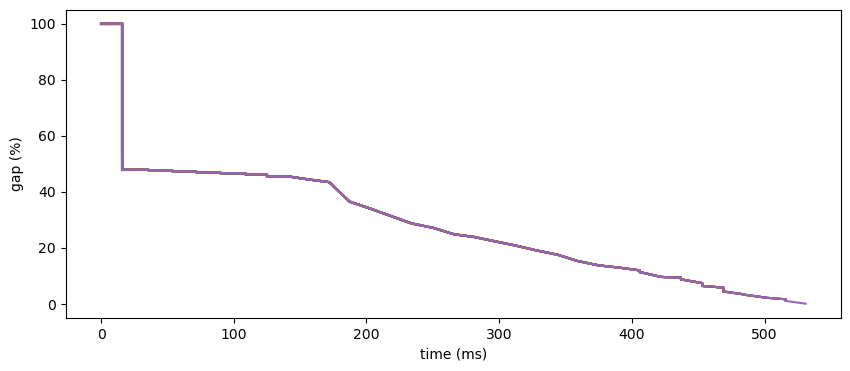

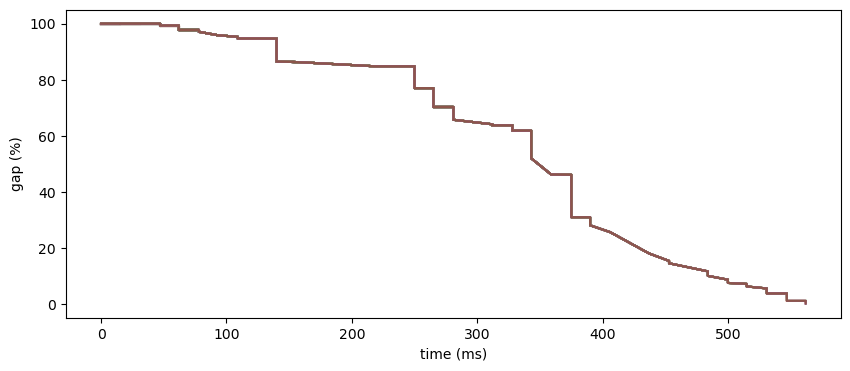

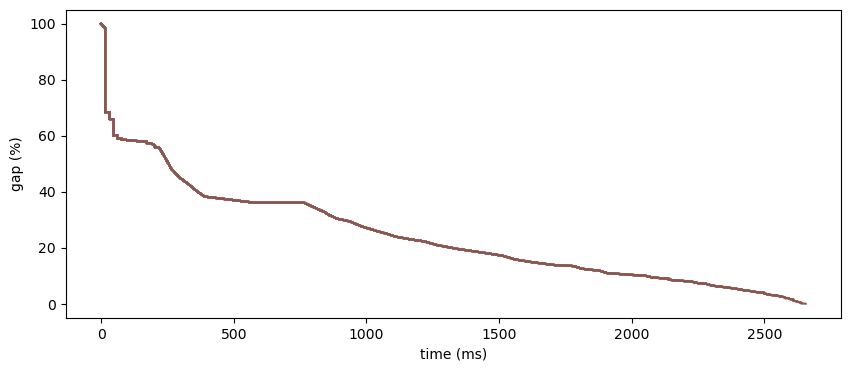

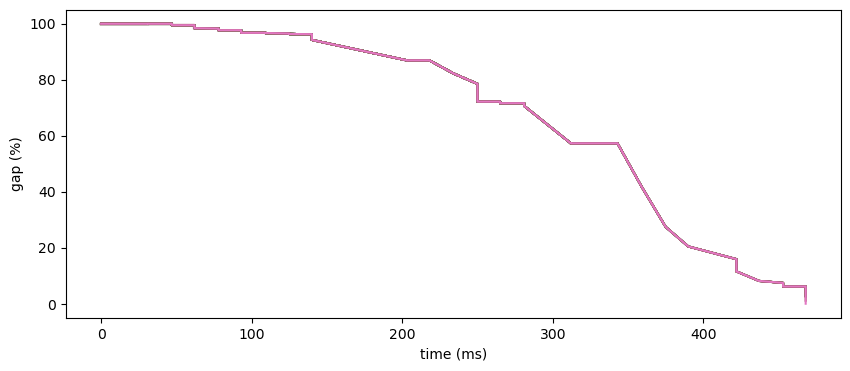

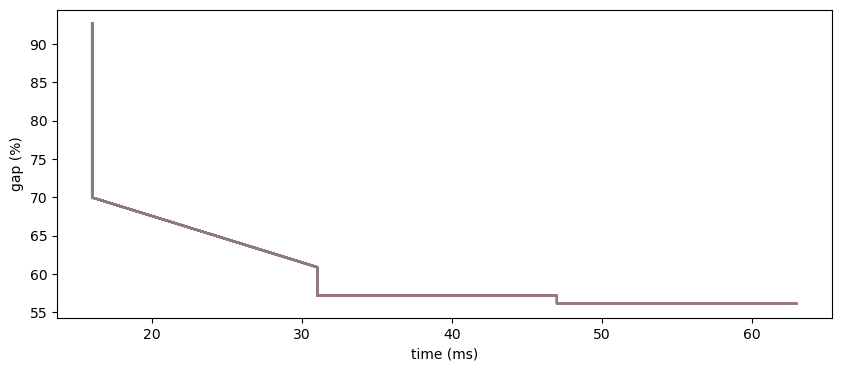

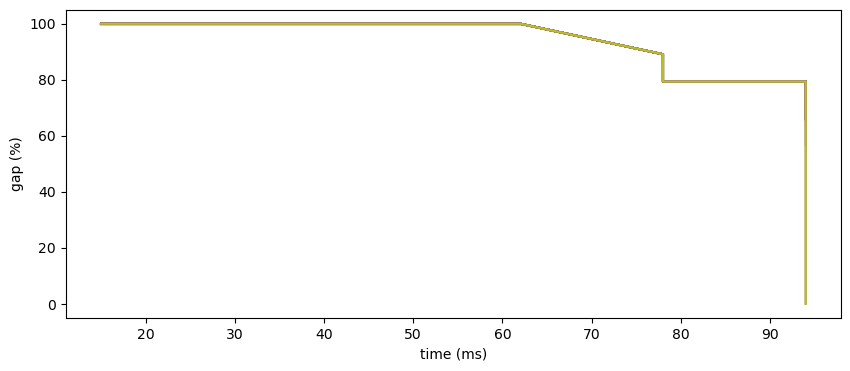

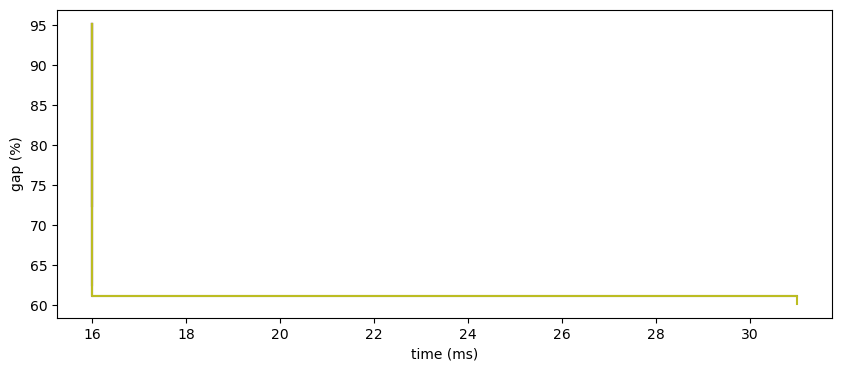

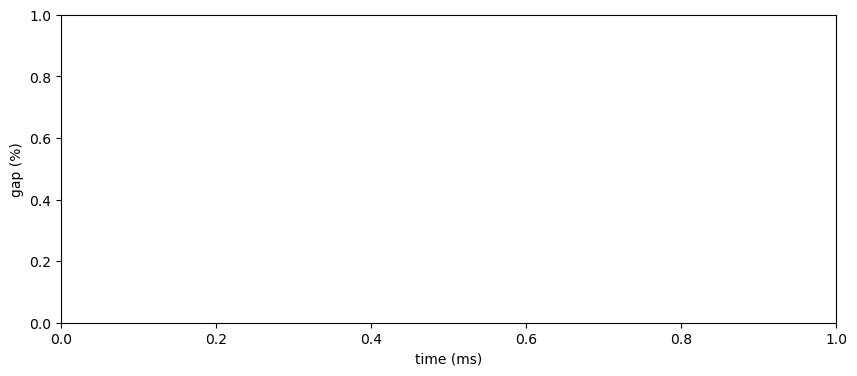

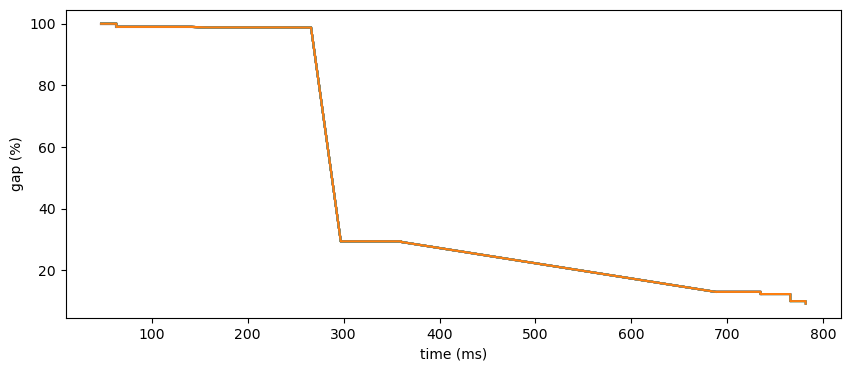

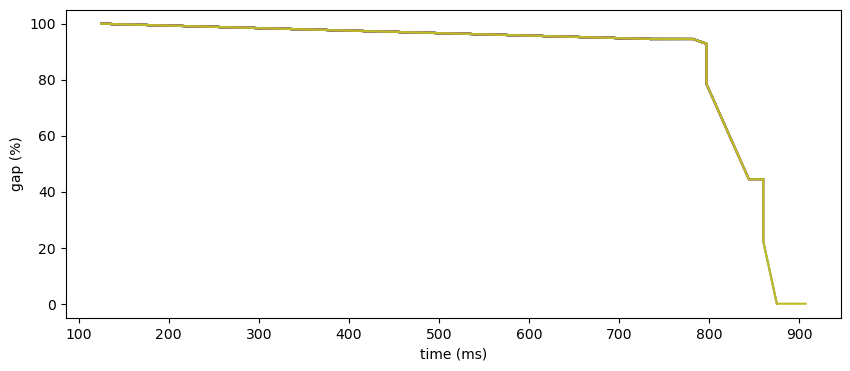

In [283]:
# file_name = f"./Data/airland{i}.txt"
R = [1, 2] 

for i in range(1, 9):
    for j in R:
        mdl_ = MIP_model(f"./Data/airland{i}.txt", j)
        mdl_.report()
        mdl_.print_solution()
        print(mdl_.solve_details)

## The CP model

In [10]:
def read_datafiles_cp(file):
    with open(file, 'r') as data:
        data_lines = data.readlines()
        number_planes = int(data_lines[0].split()[0])
        freeze_time =  int(data_lines[0].split()[1])
        mixed_data = [line.split() for line in data_lines[1:] if not line.isspace()]
        mixed_data = [[(float(j)) for j in i] for i in mixed_data]
        
        flight_details = np.empty([0,6],dtype=float)
        separation_time = np.empty([0,number_planes],dtype=float)
        
        flag = 0
       
        for element in mixed_data:
            if flag == 0: # flight details
                flight_details = np.vstack([flight_details, np.array(element)])
                flag = 1
                element_final = []
            else:  # separation_times
                element_final.extend(element)
                if len(element_final) == number_planes:
                    separation_time = np.vstack([separation_time, np.array(element_final)])
                    flag = 0

        minimum = min(flight_details[:,1])
        maximum = max(flight_details[:,3])
        num_periods = int(minimum % 10)
        int_size = (maximum-minimum)//num_periods #CT: Adicionei max-min
        period_constraints = []

        x = (0,0)
        lst = list(x)
        for i in range(num_periods-1): #CT: Adicionei -1 
            lst[0], lst[1] = int_size * i, int_size * (i+1)
            x = tuple(lst)
            period_constraints.append(x)

                
        print(f" number planes: {number_planes}")
        print(f" num_periods: {num_periods}")
        print(f" flight details: {flight_details}")
        print(f" period_constraints: {period_constraints}")
    
    return number_planes, num_periods, flight_details, separation_time, period_constraints #CT:added separation time

In [11]:
read_datafiles_cp("./Data/airland1.txt")

 number planes: 10
 num_periods: 9
 flight details: [[ 54. 129. 155. 559.  10.  10.]
 [120. 195. 258. 744.  10.  10.]
 [ 14.  89.  98. 510.  30.  30.]
 [ 21.  96. 106. 521.  30.  30.]
 [ 35. 110. 123. 555.  30.  30.]
 [ 45. 120. 135. 576.  30.  30.]
 [ 49. 124. 138. 577.  30.  30.]
 [ 51. 126. 140. 573.  30.  30.]
 [ 60. 135. 150. 591.  30.  30.]
 [ 85. 160. 180. 657.  30.  30.]]
 period_constraints: [(0.0, 72.0), (72.0, 144.0), (144.0, 216.0), (216.0, 288.0), (288.0, 360.0), (360.0, 432.0), (432.0, 504.0), (504.0, 576.0)]


(10, 9, array([[ 54., 129., 155., 559.,  10.,  10.],
        [120., 195., 258., 744.,  10.,  10.],
        [ 14.,  89.,  98., 510.,  30.,  30.],
        [ 21.,  96., 106., 521.,  30.,  30.],
        [ 35., 110., 123., 555.,  30.,  30.],
        [ 45., 120., 135., 576.,  30.,  30.],
        [ 49., 124., 138., 577.,  30.,  30.],
        [ 51., 126., 140., 573.,  30.,  30.],
        [ 60., 135., 150., 591.,  30.,  30.],
        [ 85., 160., 180., 657.,  30.,  30.]]), array([[9.9999e+04, 3.0000e+00, 1.5000e+01, 1.5000e+01, 1.5000e+01,
         1.5000e+01, 1.5000e+01, 1.5000e+01, 1.5000e+01, 1.5000e+01],
        [3.0000e+00, 9.9999e+04, 1.5000e+01, 1.5000e+01, 1.5000e+01,
         1.5000e+01, 1.5000e+01, 1.5000e+01, 1.5000e+01, 1.5000e+01],
        [1.5000e+01, 1.5000e+01, 9.9999e+04, 8.0000e+00, 8.0000e+00,
         8.0000e+00, 8.0000e+00, 8.0000e+00, 8.0000e+00, 8.0000e+00],
        [1.5000e+01, 1.5000e+01, 8.0000e+00, 9.9999e+04, 8.0000e+00,
         8.0000e+00, 8.0000e+00, 8.0000e+00, 8

In [56]:
from docplex.cp.model import CpoModel

def CP_model(file_name, R):
    # Create a new model
    mdl = CpoModel()

    P, freeze_time, flight_details, separation_time = read_datafiles(file_name)

    # The first column relates to the actual appearence time of the plane so will not be taken into account for our decision variables
    E = flight_details[:,1]  # earliest landing time
    T = flight_details[:,2]  # target landing time
    L = flight_details[:,3]  # latest landing time
    g = flight_details[:,4]  # penalty cost per unit of time for landing before target
    h = flight_details[:,5]  # penalty cost per unit of time for landing after target
    range_LT = max(flight_details[:,3]) - min(flight_details[:,1])  # landing range time

    s = separation_time  # here we consider separation time between planes that land in different runways, fundamentally their value is the same as the separation time matrix but in constraints it should be multiplied by the binary variable that says if the planes land in the same runway or not

    ij = [(i,j) for i in np.arange(P) for j in np.arange(P)]  # indexes for plane i and j landing in the same runway
    ir = [(i, r) for i in np.arange(P) for r in np.arange(R)]  # indexes for plane i landing in runway r

    # Creating the time spaces
    W = []
    V = []
    U = []
    for i in np.arange(P):
      for j in np.arange(P):
        if i != j:
          min_range_i, min_range_j, max_range_i, max_range_j = E[i], E[j], L[i], L[j]
          land_range_i = [min_range_i, max_range_i]
          land_range_j = [min_range_j, max_range_j]

          overlap = max(0, min(land_range_i[1], land_range_j[1]) - max(land_range_i[0], land_range_j[0]))  # Check if landing intervals overlap

          # To confirm if the separation time window is safe we should see if latest landing time of plane i plus the separation time
          # between plane i and j is lower and then the earliest landing time for plane j

          # This way we are also confirming that i lands before j

          if (overlap == 0) and ((L[i] + separation_time[i,j]) < E[j]):  # confirm that the windows don't intersept and separation time is big enough
            W.append((i,j))
          else:
            if (L[i] < E[j]):  # windows intersept but we know that i lands before j
              V.append((i,j))
            else:
              U.append((i,j))  # we don't know the order in which one lands
        else:
          continue

    # Defining decision variables

    alpha = mdl.integer_var_list(P, 0, int(max(L)), name="alpha")  # how soon a plane lands before target time
    beta  = mdl.integer_var_list(P, 0, int(max(L)), name="beta")  # how soon a plane lands after target time
    x = [mdl.integer_var(int(E[i]), int(L[i]), name="x_{}".format(i)) for i in np.arange(P)]  # landing time for a plane

    #sigma = mdl.binary_var_list(P, name="sigma")  # binary variable: 1 if plane i lands before plane j, 0 elsewhere
    sigma = {}
    for i, j in ij:
      sigma[i, j] = mdl.binary_var(name="sigma_{}_{}".format(i, j)) # binary variable: 1 if plane i lands before plane j, 0 elsewhere
    y = {}
    for i, r in ir:
      y[i, r] = mdl.binary_var(name="y_{}_{}".format(i, r))# 1 if plane i lands on runway  r , 0 otherwise
    
    z = {}
    for i, j in ij:
      z[i, j] = mdl.binary_var(name="z_{}_{}".format(i, j))# 1 if plane i lands on runway  r , 0 otherwise

    # Defining constraints
    for i in np.arange(P):
      mdl.add(x[i] >= E[i]) # Const 1 - Landing time of plane i must be later than the earliest landing time
      mdl.add(x[i] <= L[i]) # Const 1 - Landing time of plane i must be earlier than the before latest landing time
      mdl.add(alpha[i] >= T[i] - x[i]) # Const 14 - How soon plane i lands before T[i] must be larger than T[i] - x[i]
      mdl.add(alpha[i] <= T[i] - E[i]) # Const 15 - How soon plane i lands before T[i] must be smaller than T[i] - E[i]
      mdl.add(alpha[i] >= 0) # Const 15 - How soon plane i lands before T[i] must be at least zero
      mdl.add(beta[i] >= x[i] - T[i])  # Const 16 - How soon plane i lands after T[i] must be larger than x[i] - T[i]
      mdl.add(beta[i] <= L[i] - T[i])  # Const 17 - How soon plane i lands after T[i] must be smaller than L[i] - T[i]
      mdl.add(beta[i] >= 0)  # Const 17 - How soon plane i lands after T[i] must be at least zero
      mdl.add(x[i] == T[i] - alpha[i] + beta[i])  # Const 18 - Landing time is equal to target time minus arriving early or plus arriving late

    # Const 2 - Plain i must land before plain j or plain j before plain i
    for i in range(P):
      for j in range(P):
        if i != j:
          mdl.add(sigma[i,j] + sigma[j,i] == 1)
    
    # Const 6 - If plane i lands before j we know that they belong in subspace W or V 
    for i in range(P):
      for j in range(P):
        if ((i,j) in V) or ((i,j) in W):
          mdl.add(sigma[i,j] == 1)
          
    # Const 12 - Separation time between plane i and plane j must be respected
    for i in range(P):
      for j in range(P):
        if (i and j) in U:
          mdl.add(x[j] >= (x[i] + (separation_time[i,j]*sigma[i,j]) - ((L[i] - E[j])*sigma[j,i])))  
    
    # Const 28 - Plane i can only land in 1 runaway
    for i in np.arange(P):
        mdl.add(mdl.sum([y[i, r] for r in np.arange(R)]) == 1) 

    # Const 29 - Symetry constraint: If plane i lands in the same runaway as plane j, plane j lands in the same runaway as plane i
    for i in np.arange(P):
      for j in np.arange(P):
        if j > i:
          mdl.add(z[i,j]==z[j,i]) 

    # Const 30 - If there is any runaway r for which y[i,r]=y[j,r]=1 then z[i,j]=1. If z[i,j]=0 then the planes i and j cannot land on the same runaway 
    for i in np.arange(P):
      for j in np.arange(P):
        for r in np.arange(R):
          if j > i:
            mdl.add(z[i,j] >= y[i,r] + y[j,r]-1)

    # Const 31 - Landing times should respect separation times considering if they land in the same runway or not in subspace V
    for i in range(P):
      for j in range(P):
        if (i,j) in V:
          mdl.add(x[j] >= (x[i] + separation_time[i,j]*z[i,j] + s[i,j]*(1-z[i,j])))

    # Const 33 - Landing times should respect separation times considering if they land in the same runway or not in subspace U
    for i in range(P):
      for j in range(P):
        if (i and j) in U:
          mdl.add(x[j] >= (x[i] + separation_time[i,j]*z[i,j] + s[i,j]*(1-z[i,j] - (L[i] + max(separation_time[i,j], s[i,j]) - E[j])*sigma[j,i])))
    # Objective function
    mdl.minimize(mdl.sum(g[i] * alpha[i] + h[i] * beta[i] for i in np.arange(P)))

    # Solve model
    solution = mdl.solve()

    # Print solution
    for i in range(P):
      print("Plane {} lands at {}".format(i, solution.get_var_solution(x[i])))


In [57]:
file_name = "./Data/airland2.txt"
R = 2
CP_model(file_name, R)

 ! --------------------------------------------------- CP Optimizer 22.1.0.0 --
 ! Minimization problem - 495 variables, 675 constraints
 ! Presolve      : 210 extractables eliminated
 ! Initial process time : 0.00s (0.00s extraction + 0.00s propagation)
 !  . Log search space  : 677.4 (before), 677.4 (after)
 !  . Memory usage      : 574.4 kB (before), 574.4 kB (after)
 ! Using parallel search with 2 workers.
 ! ----------------------------------------------------------------------------
 !          Best Branches  Non-fixed    W       Branch decision
                        0        495                 -
 + New bound is 0
 *             0      163  0.03s        1      (gap is 0.00%)
 ! ----------------------------------------------------------------------------
 ! Search completed, 1 solution found.
 ! Best objective         : 0 (optimal - effective tol. is 0)
 ! Best bound             : 0
 ! ----------------------------------------------------------------------------
 ! Number of bra